주식과 국채를 60:40 비중으로 투자하는 전통적인 전략보다 한 단계 나아가 금을 추가하는 전략입니다. 금은 주식과 국채 모두와 상관관계가 작아 둘이 동반 하락하는 시기를 방어하고, 인플레이션에 강한 특징을 가집니다. 주식, 국채, 금, 현금을 각각 25%씩 보유하는 전략으로 영구 포트폴리오라는 이름을 가집니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


금 ETF인 GLD가 2004-11-18 데이터부터 있으므로, 그 시점부터 시작합니다.

In [2]:
# VTSMX (미국 주식), VUSTX (미국 국채), GLD (금), SHY (단기 국채)

start = '2004-11-18'
end = '2021-02-12'

vtsmx = web.DataReader('VTSMX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
vustx = web.DataReader('VUSTX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
gld = web.DataReader('GLD', 'yahoo', start, end)['Adj Close'].to_frame("Close")
shy = web.DataReader('SHY', 'yahoo', start, end)['Adj Close'].to_frame("Close")

Backtrader 패키지의 input 형태를 맞춥니다.

In [3]:
for column in ['Open', 'High', "Low"]:
    vtsmx[column] = vtsmx["Close"]
    vustx[column] = vustx["Close"]
    gld[column] = gld["Close"]
    shy[column] = shy["Close"]

주식, 국채, 금, 현금(단기국채) 각각을 25%씩 매수 후 20 거래일마다 리밸런싱하는 것으로 가정합니다.

In [4]:
class AssetAllocation_Permanent(bt.Strategy):
    params = (
        ('equity',0.25),
        ('treasury', 0.25),
        ('gold', 0.25),
        ('cash', 0.25)
    )
    def __init__(self):
        self.VTSMX = self.datas[0]
        self.VUSTX = self.datas[1]
        self.GLD = self.datas[2]
        self.SHY = self.datas[3]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTSMX, target=self.params.equity)
            self.order_target_percent(self.VUSTX, target=self.params.treasury)
            self.order_target_percent(self.GLD, target=self.params.gold)
            self.order_target_percent(self.SHY, target=self.params.cash)
        self.counter += 1

In [5]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTSMX = bt.feeds.PandasData(dataname = vtsmx)
VUSTX = bt.feeds.PandasData(dataname = vustx)
GLD = bt.feeds.PandasData(dataname = gld)
SHY = bt.feeds.PandasData(dataname = shy)

cerebro.adddata(VTSMX)
cerebro.adddata(VUSTX)
cerebro.adddata(GLD)
cerebro.adddata(SHY)

cerebro.addstrategy(AssetAllocation_Permanent)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

quantstats.reports.html(returns, output = 'Report_AssetAllocation_Permanent.html', title='AssetAllocation_Permanent')

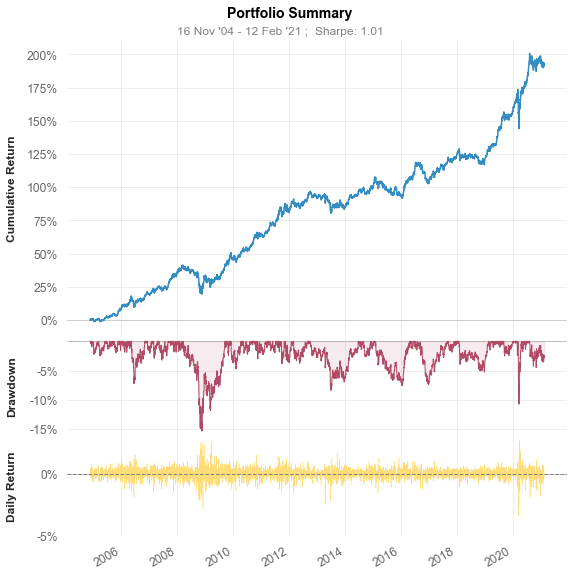

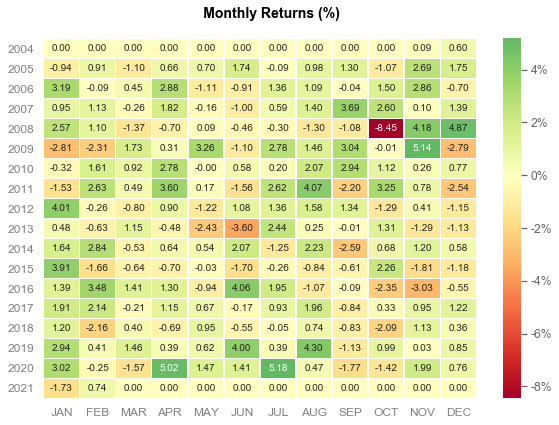

In [6]:
quantstats.reports.plots(returns, mode='basic')

In [7]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-11-17
End Period                 2021-02-12
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          192.17%
CAGR%                      6.82%
Sharpe                     1.01
Sortino                    1.44
Max Drawdown               -15.29%
Longest DD Days            628
Volatility (ann.)          6.8%
Calmar                     0.45
Skew                       -0.32
Kurtosis                   5.31

Expected Daily %           0.03%
Expected Monthly %         0.55%
Expected Yearly %          6.14%
Kelly Criterion            8.82%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.68%
Expected Shortfall (cVaR)  -0.68%

Payoff Ratio               0.99
Profit Factor              1.19
Common Sense Ratio         1.19
CPC Index                  0.64
Tail Ratio                 0.99
Outlier Win Ratio          3.57
Outlier Loss Ratio         3.8